# COVID-19 Prediction Analysis

In [1]:
# Suppress warning messages
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import general dependencies
import os 
import pandas as pd
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import datetime

In [ ]:
# #Import connection dependencies
# import sqlalchemy
# from sqlalchemy.ext.automap import automap_base
# from sqlalchemy.orm import Session
# from sqlalchemy import create_engine, func
# import psycopg2

In [4]:
# Import machine learning dependencies 
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
# import keras_tuner as kt

### Data Source

**Our World in Data COVID-19 Dataset Citation**
Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: [Our World In Data / Coronavirus](https://ourworldindata.org/coronavirus)

The OWID COVID-19 data entry started on January 1st, 2020 and has been daily updated till July 4th, 2022 when we pulled the dataset from the [OWID/COVID-19-data GitHub Repository](https://github.com/owid/covid-19-data/tree/master/public/data).

In [5]:
# Load the cases prediction cleaned data file.
cases_file_path = Path('./Resources/cases_pred.csv')
df = pd.read_csv(cases_file_path)
print(df.shape)
df.head()

(112069, 30)


,id_row,location,covid_days,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,reproduction_rate,total_vaccinations,people_fully_vaccinated,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
0,34,Afghanistan,88,114.0,8.0,11.429,0.287,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
1,35,Afghanistan,89,114.0,0.0,10.571,0.265,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
2,36,Afghanistan,90,166.0,52.0,17.714,0.445,1.53,0.0,0.0,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
3,37,Afghanistan,91,192.0,26.0,16.857,0.423,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
4,38,Afghanistan,92,235.0,43.0,22.143,0.556,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [6]:
# Set the id_row column as index and reorder records by id.
df = df.set_index('id_row').sort_values(by='id_row')
print(df.shape)
df.head()

(112069, 29)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,11.429,0.287,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,10.571,0.265,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,17.714,0.445,1.53,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,16.857,0.423,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,22.143,0.556,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112069 entries, 34 to 198747
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   location                                112069 non-null  object 
 1   covid_days                              112069 non-null  int64  
 2   total_cases                             112069 non-null  float64
 3   new_cases                               112069 non-null  float64
 4   new_cases_smoothed                      111964 non-null  float64
 5   new_cases_smoothed_per_million          111964 non-null  float64
 6   reproduction_rate                       112069 non-null  float64
 7   total_vaccinations                      112069 non-null  float64
 8   people_fully_vaccinated                 112069 non-null  float64
 9   stringency_index                        112069 non-null  float64
 10  population                              112

To predict the daily number of new COVID-19 cases, we will focus on processing the following columns and creating new features off of these: (**total_cases, new_cases, total_cases_per_100K, new_cases_per_100K, reproduction_rate, total_vaccinations, people_fully_vaccinated, total_vaccinations_per_100K, people_fully_vaccinated_per_100K, stringency_index, population, population_density, median_age, aged_65_older, gdp_per_capita, cardiovasc_death_rate, diabetes_prevalence, life_expectancy, human_development_index, daily_vacciantions, daily_people_fully_vaccinated, daily_vaccinations_per_100K, daily_people_fully_vaccinated_per_100K**). 

We presume that vaccination  has played an integral role in the COVID-19 pandemic trajectory, and its influence may be observed over both COVID-19 cases and deaths.

We will not be using smoothed numbers for now, but we will leave these columns in a separate dataframe that contains averages in case we were able to revisit the code and run a more elaborate feature engineering including calculating rolling averages of daily vaccines and people_fully_vaccinated. At that point, we could use the cleaned dataframe and handle the missing values of the smoothed columns: (**new_cases_smoothed, new_cases_smoothed_per_million, new_vaccinations_smoothed, new_vaccinations_smoothed_per_million**).

The reason we will leave **female_smokers** and **male_smokers** out of the new_cases prediction features for now is the substantial number of missing values. 
*Reconsider* including **female_smokers**, and **male_smokers** in the features for new_cases prediction model if the model needs feature enhancement. The logic behind it is that smokers might be more symptomatic when infected with COVID-19, hence they seek testing and that would increase the documented number of the cases. Same concept applies to the populations' rates of cardiovascular_death and diabetes_prevalence. 

In [8]:
# Drop unnecessary columns.
cols_drop = ['new_cases_smoothed', 'new_cases_smoothed_per_million',
            'female_smokers', 'male_smokers']
focused_general_df = df.drop(columns=cols_drop, axis=1)
print(focused_general_df.shape) 
focused_general_df.info()

(112069, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112069 entries, 34 to 198747
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   location                                112069 non-null  object 
 1   covid_days                              112069 non-null  int64  
 2   total_cases                             112069 non-null  float64
 3   new_cases                               112069 non-null  float64
 4   reproduction_rate                       112069 non-null  float64
 5   total_vaccinations                      112069 non-null  float64
 6   people_fully_vaccinated                 112069 non-null  float64
 7   stringency_index                        112069 non-null  float64
 8   population                              112069 non-null  float64
 9   population_density                      112069 non-null  float64
 10  median_age                    

In [9]:
# Check missing values in the focused dataframe
focused_general_df.isnull().sum()

location                                   0
covid_days                                 0
total_cases                                0
new_cases                                  0
reproduction_rate                          0
total_vaccinations                         0
people_fully_vaccinated                    0
stringency_index                           0
population                                 0
population_density                         0
median_age                                 0
aged_65_older                              0
gdp_per_capita                             0
cardiovasc_death_rate                      0
diabetes_prevalence                        0
life_expectancy                            0
human_development_index                    0
daily_vaccinations                         0
daily_people_fully_vaccinated              0
total_cases_per_100K                       0
new_cases_per_100K                        78
total_vaccinations_per_100K                0
people_ful

In [10]:
# Check missing values from new_cases_per_100K
check_df = focused_general_df[['new_cases', 'population', 'new_cases_per_100K']]
see_nulls = check_df.loc[check_df.new_cases_per_100K.isnull()]
see_nulls.head(10)

,new_cases,population,new_cases_per_100K
id_row,,,
679,0.0,3.983543e+07,NaN
6400,0.0,9.872800e+04,NaN
11096,0.0,2.578822e+07,NaN
11112,0.0,2.578822e+07,NaN
13572,0.0,3.969140e+05,NaN
18998,0.0,1.245103e+07,NaN
24929,0.0,2.139934e+08,NaN
25383,0.0,2.139934e+08,NaN
27143,0.0,4.415320e+05,NaN


In [11]:
# Replace the missing values in the normalized new_cases_per_100K column with a rate calculation.
focused_general_df.new_cases_per_100K.fillna(focused_general_df.new_cases / focused_general_df.population * 100000, inplace=True)
focused_general_df.isnull().sum()

location                                  0
covid_days                                0
total_cases                               0
new_cases                                 0
reproduction_rate                         0
total_vaccinations                        0
people_fully_vaccinated                   0
stringency_index                          0
population                                0
population_density                        0
median_age                                0
aged_65_older                             0
gdp_per_capita                            0
cardiovasc_death_rate                     0
diabetes_prevalence                       0
life_expectancy                           0
human_development_index                   0
daily_vaccinations                        0
daily_people_fully_vaccinated             0
total_cases_per_100K                      0
new_cases_per_100K                        0
total_vaccinations_per_100K               0
people_fully_vaccinated_per_100K

## Data Exploration

In [12]:
# Count the number of locations in the focused_general_df
print(f"There are {focused_general_df.location.nunique()} locations in the cleaned dataframe.")

There are 177 locations in the cleaned dataframe.


In [13]:
# Check the date range. 
focused_general_df.covid_days.sort_values()

id_row
36732      22
36733      23
36734      24
36735      25
36736      26
         ... 
94986     817
94573     817
6723      817
99223     817
198747    817
Name: covid_days, Length: 112069, dtype: int64

The cleaned dataframe contained location_specific COVID-19 entries starting at day 22nd of the pandemic, and up to day 817th of the pandemic. 

In [14]:
# Check the count of records for each location
locations_records = focused_general_df.location.value_counts()
locations_records

South Korea        767
Italy              764
Singapore          758
France             758
Germany            757
                  ... 
Kiribati            55
Solomon Islands     51
Tonga               39
Vanuatu             18
Samoa                6
Name: location, Length: 177, dtype: int64

<AxesSubplot:ylabel='Density'>

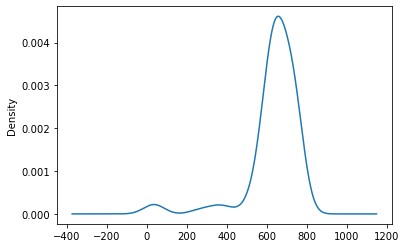

In [15]:
# Visualize locations' records.
locations_records.plot.density()

In [16]:
# Check the population range in the cleaned dataframe.
print(f"Population min: {focused_general_df.population.min()}")
print(f"Population max: {focused_general_df.population.max()}")

Population min: 98728.0
Population max: 1444216102.0


### Population Splitting

To facilitate the machine learning model application, we split the dataset based on population and applied the model to countries with populations of 1 million and above.

Create a population-based DataFrame: 
- mill_countries_df: Population more than 1 million.

#### Population 1 million and above

In [17]:
# Create 1 million and above population DataFrame for cases_pred_df.
cases_mill_countries_df = focused_general_df[(focused_general_df["population"] >= 1000000)]
print(cases_mill_countries_df.shape)
cases_mill_countries_df.head()

(99856, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [18]:
# Check the names and count of countries with population more than 1 mill.
cases_mill_countries_list = cases_mill_countries_df["location"].unique()
print(f" There are {len(cases_mill_countries_list)} countries with population of 1 million and above.")
cases_mill_countries_list

 There are 150 countries with population of 1 million and above.


array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyz

In [19]:
# Check the records count of 1 million+ countries.
cases_mill_pop_records = cases_mill_countries_df.location.value_counts()
cases_mill_pop_records

South Korea         767
Italy               764
Singapore           758
France              758
Germany             757
                   ... 
Botswana            549
Papua New Guinea    543
Angola              543
Timor               327
Laos                279
Name: location, Length: 150, dtype: int64

##### PHASE 1 DATAFRAME:  apply only on countries with population of 1 million and above.

In [20]:
cases_mill_countries_df.shape

(99856, 25)

In [21]:
cases_mill_countries_df.location.nunique()

150

In [22]:
cases_mill_countries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99856 entries, 34 to 198747
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   location                                99856 non-null  object 
 1   covid_days                              99856 non-null  int64  
 2   total_cases                             99856 non-null  float64
 3   new_cases                               99856 non-null  float64
 4   reproduction_rate                       99856 non-null  float64
 5   total_vaccinations                      99856 non-null  float64
 6   people_fully_vaccinated                 99856 non-null  float64
 7   stringency_index                        99856 non-null  float64
 8   population                              99856 non-null  float64
 9   population_density                      99856 non-null  float64
 10  median_age                              99856 non-null  

In [ ]:
# # Export the cases prediction DataFrame of countries with 1 mill+ to a csv file.
# cases_1mill_output_file = Path("./Resources/cases_1mill_pred.csv")
# cases_mill_countries_df.to_csv(cases_1mill_output_file, index=True)

## Covid Days Splitting

In light of the changing nature of the COVID-19 virus and the emergent new variants, we will be looking at data from the first 2 years of the pandemic when the public health measures were more strict. 

In [23]:
# Create a 2-yr (720) DataFrame 
cases_1mill_2yr_df = cases_mill_countries_df[cases_mill_countries_df["covid_days"] <= 725]
print(cases_1mill_2yr_df.shape)
cases_1mill_2yr_df.head()

(88039, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [27]:
# # Export the cases prediction DataFrame of countries with 1 mill+ and 720 covid_days to a csv file.
# cases_1mill_2yr_output_file = Path("./Resources/cases_1mill_2yr_df.csv")
# cases_1mill_2yr_df.to_csv(cases_1mill_2yr_output_file, index=True)

In [25]:
# Create a 700 days DataFrame 
cases_1mill_700_df = cases_mill_countries_df[cases_mill_countries_df["covid_days"] <= 700]
print(cases_1mill_700_df.shape)
cases_1mill_700_df.head()

(84848, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [28]:
# # Export the cases prediction DataFrame of countries with 1 mill+ and 700 days covid_days to a csv file.
# cases_1mill_700_output_file = Path("./Resources/cases_1mill_700_df.csv")
# cases_1mill_700_df.to_csv(cases_1mill_700_output_file, index=True)

# Prediction Models

Random forest models use a number of weak learner algorithms (decision trees) and combine their output to make a final regression decision.

Deep learning models evaluate input data within a single neuron, as well as across multiple neurons and layers.

Deep learning model might be able to identify variability in a dataset that a random forest model could miss. However, a random forest model with a sufficient number of estimators and tree depth should be able to perform at a similar capacity to most deep learning models.

To compare the implementation and performance of a random forest model versus a deep learning model, we'll train and evaluate both models on the same data. This time, we'll use the countries of 1 mill+ dataset that has been adapted from the OWID COVID-19 data with more than 99,000 rows and 24 potential feature columns. From this dataset, we want to build a regressor that can predict the daily numbero f COVID-19 new cases per 100,000 people provided their current total cases per 100K, vaccinations per 100K and other health and social metrics.

## Data Preprocessing

Because both Scikit-Learn's RandomForestRegression class and TensorFlow's Sequential class require preprocessing, we can perform our preprocessing steps on all of the data—no need to keep track of separate scaled and unscaled data.

The only categorical data we have is the location, which we will separate from the rest of the features. 

In [ ]:
# # Create a new DataFrame that holds only the location names.
# location_name_df = cases_mill_countries_df[["location"]].copy(deep=True)
# location_name_df.sample(10)

In [ ]:
# location_name_df.location.value_counts()

In [29]:
# Create a new DataFrame with the engineered columns for the model. 
cols_drop_phase1 = ['location', 'total_cases', 'new_cases', 'total_vaccinations', 
                   'people_fully_vaccinated', 'daily_vaccinations', 'daily_people_fully_vaccinated', 'population']
phase1_cases_df = cases_mill_countries_df.drop(columns=cols_drop_phase1, axis=1)
print(phase1_cases_df.shape)
print()
phase1_cases_df.info()

(99856, 17)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99856 entries, 34 to 198747
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   covid_days                              99856 non-null  int64  
 1   reproduction_rate                       99856 non-null  float64
 2   stringency_index                        99856 non-null  float64
 3   population_density                      99856 non-null  float64
 4   median_age                              99856 non-null  float64
 5   aged_65_older                           99856 non-null  float64
 6   gdp_per_capita                          99856 non-null  float64
 7   cardiovasc_death_rate                   99856 non-null  float64
 8   diabetes_prevalence                     99856 non-null  float64
 9   life_expectancy                         99856 non-null  float64
 10  human_development_index                 998

In [ ]:
phase1_cases_df.columns

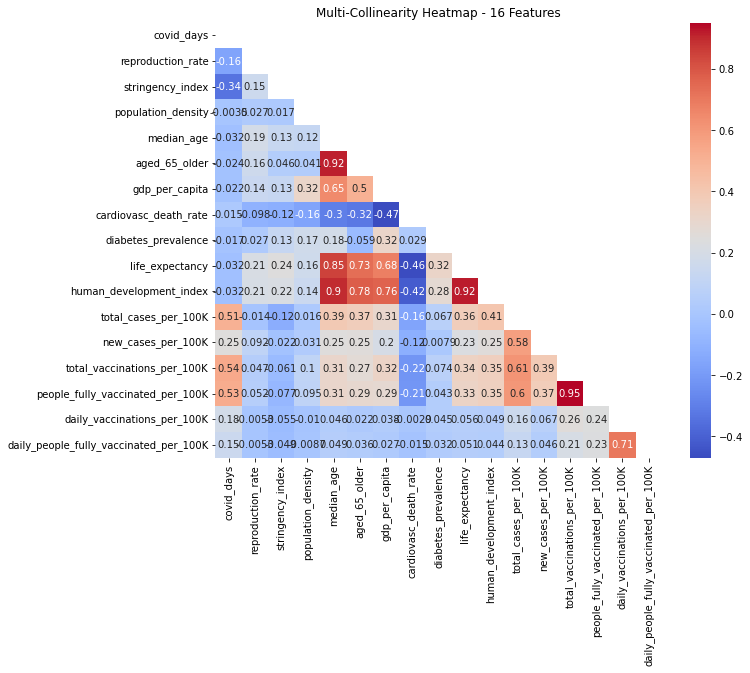

In [31]:
# Visualize the data for collinearity 
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(phase1_cases_df.corr(), dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(phase1_cases_df.corr(), annot=True, mask=mask, cmap='coolwarm')
plt.title('Multi-Collinearity Heatmap - 16 Features')
plt.show()

- If high multicollinearity exists for the control variables but not the experimental variables, then you can interpret the experimental variables without problems.
- Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity.
- If must resolve multicollinearity, here are some solutions: 
    1. Remove some of the highly correlated independent variables.
    2. Perform an analysis designed for highly correlated variables, such as principal components analysis or partial least squares regression.

- Variables such as **total_vaccinations_per_100K** & **people_fully_vaccinated_per_100K**, **life_expectancy** & **human_development_index**, **median_age** & **human_development_index**, **median_age** & **aged_65_older**, and **median_age** & **life_expectancy** are having a very strong positive correlation.
- To a lesser degree, variables such as **aged_65_older** & **human_development_index**, **gdp_per_capita** & **human_development_index**, and **aged_65_older**, & **life_expectancy** are also having a strong positive correlation. 
- **Generally speaking, a Pearson correlation coefficient value greater than 0.7 indicates the presence of multi-collinearity.**

Consider dropping one of the following corelated columns: **total_vaccinations_per_100K, people_fully_vaccinated_per_100K**. 

Consider dropping one of the following corelated columns: **life_expectancy, human_development_index**. 

Consider dropping one of the following corelated columns: **median_age, aged_65_older**. 

### STEP 1: Applying ML model on 17 Features

In [32]:
# Define Target variable
y = phase1_cases_df.new_cases_per_100K
# Define features 
X = phase1_cases_df.drop(["new_cases_per_100K"], axis=1)

In [33]:
# Show statistical description of features
X.describe()

,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
count,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000
mean,441.474684,1.008028,54.819652,202.876759,30.594998,8.984831,18818.183709,259.332345,7.297077,72.677470,0.724299,3015.599002,24451.818419,9825.939553,2467.820411,738.613575
std,210.038228,0.357605,21.415210,711.345766,9.389906,6.497550,19377.210064,121.985397,3.724317,7.687053,0.156740,5337.477175,51685.157853,21449.939494,15999.340326,5888.022715
min,22.000000,-0.030000,0.000000,1.980000,15.100000,1.144000,661.240000,79.370000,0.990000,53.280000,0.394000,0.008100,0.000000,0.000000,0.000000,0.000000
25%,261.000000,0.820000,42.130000,35.608000,21.500000,3.244000,3689.251000,156.139000,4.820000,66.600000,0.584000,86.101175,0.000000,0.000000,0.000000,0.000000
50%,433.000000,1.000000,55.560000,80.080000,29.700000,6.378000,12294.876000,245.465000,6.820000,74.480000,0.750000,519.389600,0.000000,0.000000,0.000000,0.000000
75%,621.000000,1.180000,71.300000,145.725000,39.600000,14.799000,27216.445000,329.635000,8.520000,77.970000,0.852000,3883.896600,10410.000000,1980.000000,112.509983,13.257681
max,817.000000,5.820000,100.000000,7915.731000,48.200000,27.049000,116935.600000,724.417000,22.020000,84.630000,0.957000,52395.953300,263560.000000,95130.000000,242017.647136,95132.099293


Standardize numerical variables using Scikit-Learn's StandardScaler class. <br>
We must split our data into the training and testing sets prior to standardization to not incorporate the testing values into the scale.

In [34]:
# Split the data into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [35]:
# Check the shapes of training/ testing datasets.
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (74892, 16)
X_test shape: (24964, 16)
y_train shape: (74892,)
y_test shape: (24964,)


In [ ]:
# y_train=np.reshape(y_train, (-1,1))
# y_test=np.reshape(y_test, (-1,1))

In [36]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
# Check the scaled data
X_train_scaled

array([[-0.57105937,  0.36975004, -0.3105722 , ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.51874383,  0.00620229,  1.50538332, ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.77080959,  0.28585441, -0.00799077, ..., -0.45781868,
        -0.15382825, -0.12536871],
       ...,
       [ 0.05672705,  0.00620229,  0.29459066, ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.26667808,  0.17399356,  0.3380167 , ..., -0.45781868,
        -0.15382825, -0.12536871],
       [ 1.69277648, -2.51066674, -1.43497974, ..., -0.45781868,
        -0.15382825, -0.12536871]])

## Random Forest Regression 

In [38]:
# Create a Random Forest Regression instance and train it
rf_model = RandomForestRegressor(n_estimators=128, random_state=78)

# Train the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [39]:
# Evaluate the model.
y_pred = rf_model.predict(X_test_scaled)
y_pred

array([5.91905000e+01, 4.51921875e-02, 1.14014609e+00, ...,
       0.00000000e+00, 1.49372734e+00, 0.00000000e+00])

A good MSE score will be close to zero, while a good R2 score will be close to 1. <br>
R2 score is the default scoring for many of the Sklearn models

In [40]:
# Score the model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ):  0.769
mean absolute error (MAE):  4.781
mean squared error (MSE):  570.731
Root Mean Squared Error (RMSE):  23.890


In [41]:
# Check other metrics of the RF model on testing data
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))


Mean Absolute Percentage Error (MAPE): 3796922429656361.0
Explained Variance Score: 0.768697174888701
Max Error: 1591.4733960937513
Mean Squared Log Error: 0.3545146492037214
Median Absolute Error: 0.438366015625001


In [43]:
# Check the training score
training_score = rf_model.score(X_train_scaled, y_train)
print(f"The training score for the Random Forest Regression model on 16 features is {training_score: .2f}.")

The training score for the Random Forest Regression model on 16 features is  0.97.


In [44]:
# Check the testing score
testing_score = rf_model.score(X_test_scaled, y_test)
print(f"The testing score for the Random Forest Regression model on 16 features is {testing_score: .2f}.")

The testing score for the Random Forest Regression model on 16 features is  0.77.


In [45]:
# # Overall Score for the model
# X_scaled = X_scaler.transform(X)
# rf_model.score(X_scaled, y) 

0.9204301315692255

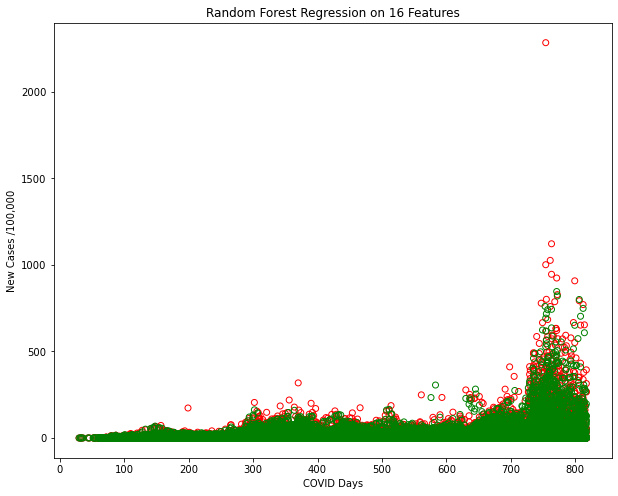

In [46]:
# Visualize the predication against the actual values
plt.figure(figsize=(10, 8))
plt.scatter(X_test['covid_days'].values, y_test, facecolors='none', edgecolors='r')
plt.scatter(X_test['covid_days'].values, y_pred, facecolors='none', edgecolors='green')

plt.title('Random Forest Regression on 16 Features')
plt.xlabel('COVID Days')
plt.ylabel('New Cases /100,000')
plt.show() 

 Because we can't easily plot our line in 3D space, we can use a residual plot to check our predictions. <br>
 Residuals are the difference between the true values of y and the predicted values of y. <br>
 We want our predictions to be close to zero on the y-axis in this plot. <br>

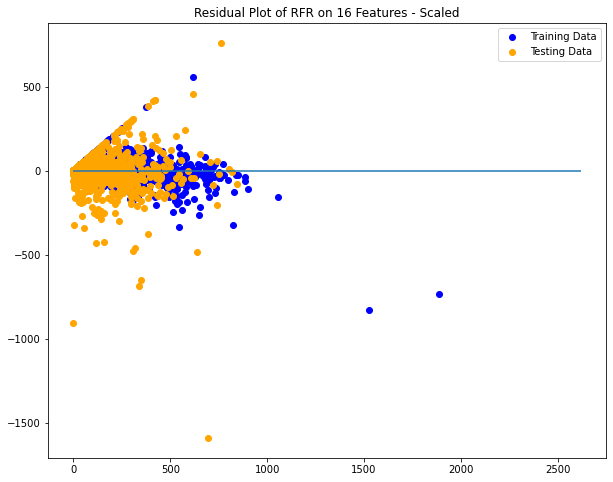

In [47]:
# Plot the predictions and their residuals for the training and testing data - SCALED.

plt.figure(figsize=(10, 8))
plt.scatter(rf_model.predict(X_train_scaled), rf_model.predict(X_train_scaled) - y_train, c="blue", label="Training Data")
plt.scatter(rf_model.predict(X_test_scaled), rf_model.predict(X_test_scaled) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot of RFR on 16 Features - Scaled")
plt.show()

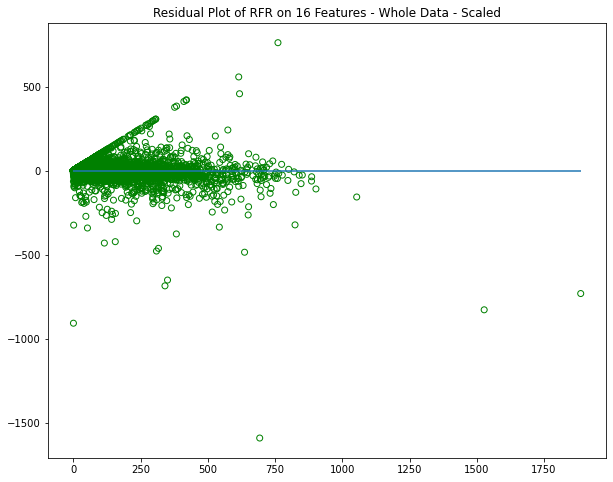

In [49]:
# Scale the whole data
X_scaled = X_scaler.transform(X)
pred_16_scaled = rf_model.predict(X_scaled)
# Plot predictions from scaled data and their Residuals
plt.figure(figsize=(10, 8))
plt.scatter(pred_16_scaled, pred_16_scaled - y, facecolors='none', edgecolors='green')
plt.hlines(y=0, xmin=pred_16_scaled.min(), xmax=pred_16_scaled.max())
plt.title("Residual Plot of RFR on 16 Features - Whole Data - Scaled")
plt.show()

Text(0.5, 1.0, 'Residuals of Whole Scaled Data Predictions - 16 Features')

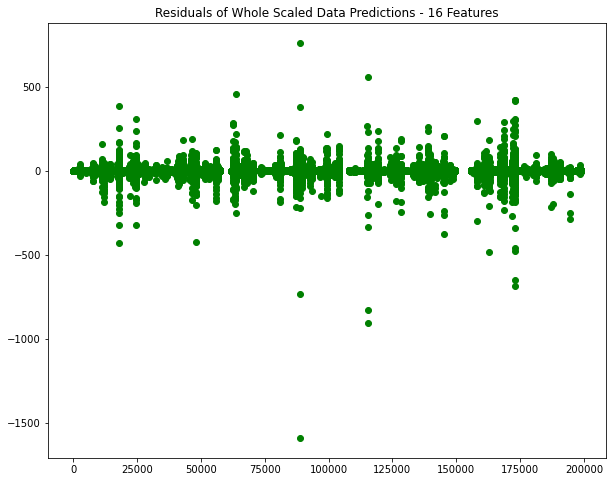

In [57]:
# Plot the residuals only of WHOLE SCALED data
plt.figure(figsize=(10, 8))
plt.plot(pred_16_scaled - y, marker='o', c='green', linestyle='')
plt.title('Residuals of Whole Scaled Data Predictions - 16 Features')

Text(0.5, 1.0, 'Residuals of Testing Data Predictions - 16 Features')

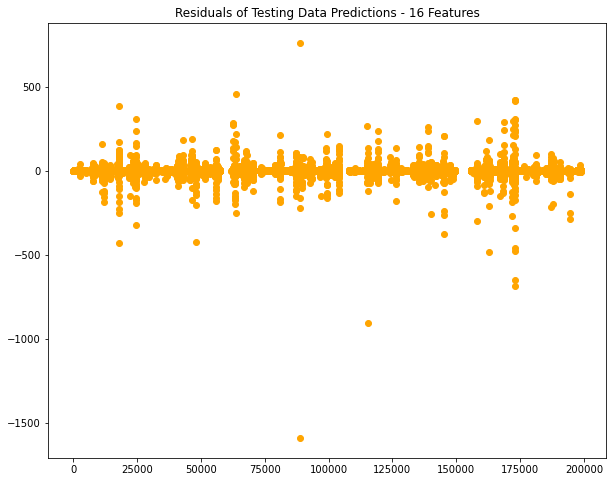

In [56]:
# Plot the residuals only of TESTING data
plt.figure(figsize=(10, 8))
plt.plot(y_pred - y_test, marker='o', c='orange', linestyle='')
plt.title('Residuals of Testing Data Predictions - 16 Features')

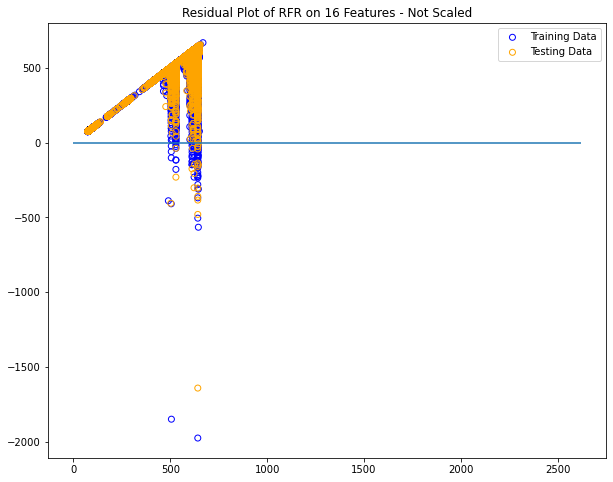

In [50]:
# Plot the predictions and their residuals for the training and testing data -NOT SCALED. 

plt.figure(figsize=(10, 8))
plt.scatter(rf_model.predict(X_train), rf_model.predict(X_train) - y_train, facecolors='none', edgecolors='blue', label="Training Data")
plt.scatter(rf_model.predict(X_test), rf_model.predict(X_test) - y_test, facecolors='none', edgecolors="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot of RFR on 16 Features - Not Scaled")
plt.show()

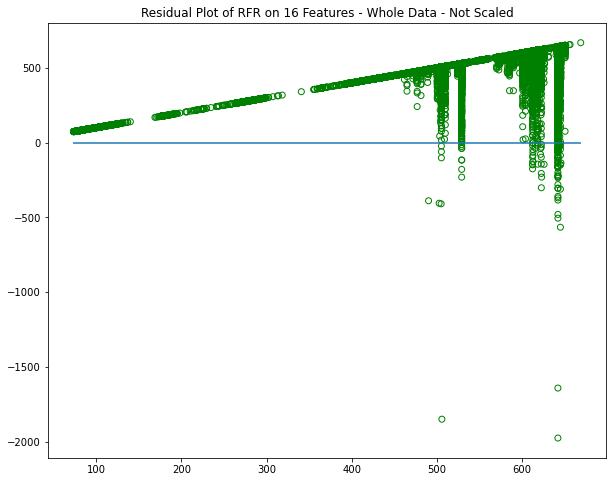

In [52]:
pred_16_notscaled = rf_model.predict(X)
# Plot predictions and their Residuals
plt.figure(figsize=(10, 8))
plt.scatter(pred_16_notscaled, pred_16_notscaled - y, facecolors='none', edgecolors='green')
plt.hlines(y=0, xmin=pred_16_notscaled.min(), xmax=pred_16_notscaled.max())
plt.title("Residual Plot of RFR on 16 Features - Whole Data - Not Scaled")
plt.show()

In [60]:
# plt.figure(figsize=(10, 8))
# plt.plot(y_pred - y_test, marker='o',linestyle='')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)

# plt.show()

In [61]:
# Create a new focused DataFrame of results of regression with their errors: UNSCALED DATA
predictions = rf_model.predict(X)
regression_notscaled_df = pd.DataFrame({"Actual": y, "Predicted": predictions, "Error": predictions - y})[["Actual", "Predicted", "Error"]]
regression_notscaled_df.head(5)

,Actual,Predicted,Error
id_row,,,
34,0.0201,79.055559,79.035459
35,0.0000,79.055559,79.055559
36,0.1305,77.241816,77.111316
37,0.0653,79.752551,79.687251
38,0.1079,81.557167,81.449267


In [67]:
# Scale the whole data SCALED
# X_scaled = X_scaler.transform(X)
# pred_16_scaled = rf_model.predict(X_scaled)
regression_scaled_df = pd.DataFrame({"Actual": y, "Predicted": pred_16_scaled, "Residuals": pred_16_scaled - y})[["Actual", "Predicted", "Residuals"]]
regression_scaled_df.head(5)

,Actual,Predicted,Residuals
id_row,,,
34,0.0201,0.033024,0.012924
35,0.0000,0.028859,0.028859
36,0.1305,0.102876,-0.027624
37,0.0653,0.073266,0.007966
38,0.1079,0.094169,-0.013731


In [68]:
# # Scale the whole data SCALED
# X_scaled = X_scaler.transform(X)
# pred_16_scaled = rf_model.predict(X_scaled)
# regression_scaled_df = pd.DataFrame({"Actual": y, "Predicted": pred_16_scaled, "Residuals": pred_16_scaled - y})[["Actual", "Predicted", "Residuals"]]
regression_scaled_df.sample(10)

,Actual,Predicted,Residuals
id_row,,,
193146,0.0348,0.035400,0.000600
141613,26.0401,25.235798,-0.804302
32322,86.7187,86.965155,0.246455
51480,1.7497,10.967864,9.218164
37033,0.0016,0.001837,0.000237
88424,7.2651,7.348864,0.083764
75372,0.0000,0.077227,0.077227
84992,9.1969,9.531775,0.334875
162429,0.7216,0.657409,-0.064191


In [69]:
# Add a new column "predictions" to the PHASE 1 Dataframe that holds the actual new cases. 
pred_cases_16_features_df = phase1_cases_df.copy()
pred_cases_16_features_df['new_cases_per_100K_predictions'] = pred_16_scaled
print(pred_cases_16_features_df.shape)
pred_cases_16_features_df.head()

(99856, 18)


,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions
id_row,,,,,,,,,,,,,,,,,,
34,88,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0201,0.0,0.0,0.0,0.0,0.033024
35,89,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0000,0.0,0.0,0.0,0.0,0.028859
36,90,1.53,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4167,0.1305,0.0,0.0,0.0,0.0,0.102876
37,91,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4820,0.0653,0.0,0.0,0.0,0.0,0.073266
38,92,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.5899,0.1079,0.0,0.0,0.0,0.0,0.094169


In [71]:
# Add a new column "residuals" to the Dataframe that holds the actual new cases and predictions.
pred_cases_16_features_df['Residuals'] = pred_cases_16_features_df['new_cases_per_100K_predictions'] - pred_cases_16_features_df['new_cases_per_100K']
print(pred_cases_16_features_df.shape)
pred_cases_16_features_df.sample(5)

(99856, 19)


,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions,Residuals
id_row,,,,,,,,,,,,,,,,,,,
198724,794,1.21,53.70,42.729,19.6,2.822,1899.775,307.846,1.82,61.49,0.571,1583.7284,1.8553,52580.0,22600.0,36.601759,11.469523,2.652108,0.796808
198215,285,1.01,71.30,42.729,19.6,2.822,1899.775,307.846,1.82,61.49,0.571,53.1468,0.0663,0.0,0.0,0.000000,0.000000,0.063952,-0.002348
136369,96,1.48,85.19,14.980,30.7,2.355,37960.709,266.342,12.61,77.86,0.813,6.3369,0.6318,0.0,0.0,0.000000,0.000000,0.607346,-0.024454
62621,749,1.00,31.94,18.136,42.8,21.228,40585.721,153.507,5.76,81.91,0.938,7588.0607,165.1659,187580.0,73810.0,1166.614789,60.918891,161.006130,-4.159770
148589,776,1.09,40.28,8.823,39.6,14.178,24765.954,431.297,6.18,72.58,0.824,9778.4095,113.1771,108570.0,48880.0,197.956958,75.739475,116.982159,3.805059


In [72]:
# # Export the RFR predictions DataFrame to a csv file.
# pred_cases_16_features_outpath = Path("./Resources/pred_cases_16_features_rfr.csv")
# pred_cases_16_features_df.to_csv(pred_cases_16_features_outpath, index=True)

In [73]:
# Add a new column "predictions" to the original Dataframe that holds all 25 columns of features, raw numbers, and location.  
pred_cases_16_features_all_df = cases_mill_countries_df.copy()
pred_cases_16_features_all_df['new_cases_per_100K_predictions'] = pred_16_scaled
print(pred_cases_16_features_all_df.shape)
pred_cases_16_features_all_df.head()

(99856, 26)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0,0.033024
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0,0.028859
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0,0.102876
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0,0.073266
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0,0.094169


In [74]:
# Add a new column "residuals" to the Dataframe that holds the actual new cases and predictions and original columns
pred_cases_16_features_all_df['Residuals'] = pred_cases_16_features_all_df['new_cases_per_100K_predictions'] - pred_cases_16_features_all_df['new_cases_per_100K']
print(pred_cases_16_features_all_df.shape)
pred_cases_16_features_all_df.sample(5)

(99856, 27)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions,Residuals
id_row,,,,,,,,,,,,,,,,,,,,,
16544,Belarus,242,71687.0,164.0,1.10,0.0,0.0,31.48,9442867.0,46.858,...,0.0,0.0,759.1656,1.7368,0.0,0.0,0.000000,0.000000,1.710063,-0.026737
101650,Liberia,756,7243.0,0.0,0.42,0.0,0.0,48.15,5180208.0,49.127,...,0.0,0.0,139.8206,0.0000,0.0,0.0,0.000000,0.000000,0.026391,0.026391
73386,Guatemala,411,167383.0,104.0,0.98,0.0,0.0,43.06,18249868.0,157.834,...,0.0,0.0,917.1738,0.5699,0.0,0.0,0.000000,0.000000,1.128134,0.558234
78999,Honduras,405,156606.0,871.0,1.03,0.0,0.0,87.96,10062994.0,82.805,...,0.0,0.0,1556.2565,8.6555,0.0,0.0,0.000000,0.000000,8.288834,-0.366666
27823,Bulgaria,540,421401.0,62.0,0.76,1709510.0,776172.0,42.59,6896655.0,65.180,...,14212.0,8449.0,6110.2230,0.8990,24790.0,11250.0,206.070914,122.508665,1.099302,0.200302


In [75]:
# # Export the RFR predictions DataFrame to a csv file containing all columns of features, raw numbers, and location. 
# pred_cases_16_features_all_outpath = Path("./Resources/pred_cases_16_features_all_rfr.csv")
# pred_cases_16_features_all_df.to_csv(pred_cases_16_features_all_outpath, index=True)

### Analyzing Feature Importance - 17 Features

In [76]:
# List the features sorted in descending order by feature importance
feature_importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.45230385252175914, 'total_cases_per_100K'),
 (0.1372335192178836, 'covid_days'),
 (0.10278321736793328, 'reproduction_rate'),
 (0.06517118398040679, 'total_vaccinations_per_100K'),
 (0.035340443586750064, 'people_fully_vaccinated_per_100K'),
 (0.02782838748550517, 'cardiovasc_death_rate'),
 (0.026232267180476648, 'daily_vaccinations_per_100K'),
 (0.02337351072976959, 'daily_people_fully_vaccinated_per_100K'),
 (0.02192899936374291, 'gdp_per_capita'),
 (0.02006354153011021, 'life_expectancy'),
 (0.017586380198962193, 'stringency_index'),
 (0.017354142989448904, 'population_density'),
 (0.016600565528457015, 'diabetes_prevalence'),
 (0.015524701411670653, 'median_age'),
 (0.011348316497841219, 'aged_65_older'),
 (0.009326970409282584, 'human_development_index')]

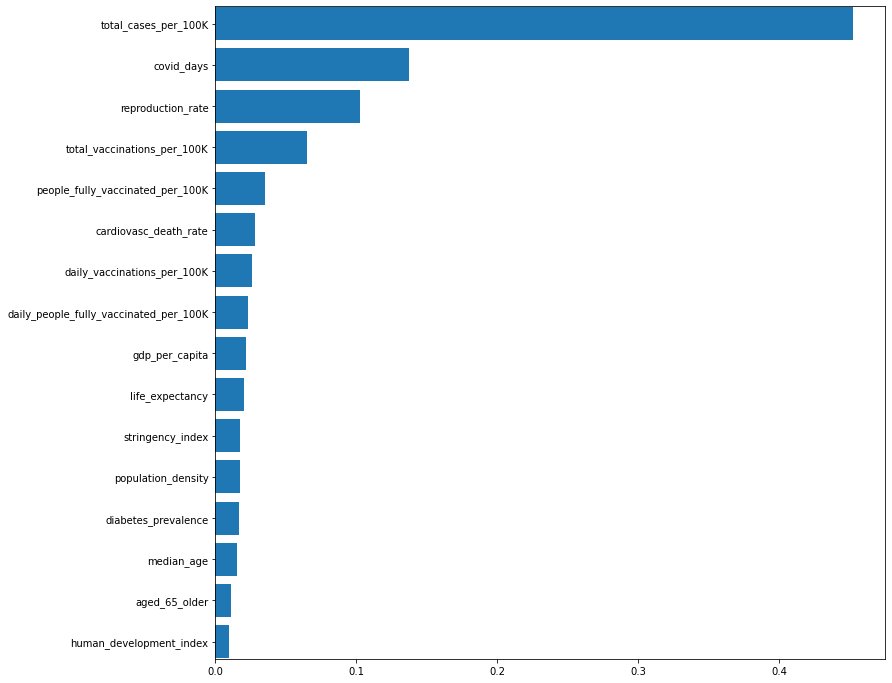

In [77]:
# Visualize Features importance 
features = sorted(zip(X.columns, rf_model.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(12, 12)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [78]:
# Reduce features for prediction based on importance and retrain the model
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(rf_model)
sel.fit(X_train_scaled, y_train)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=128,
                                                random_state=78))

In [79]:
# Split selected features into training and testing subsets then standardize.
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

In [80]:
# Create a new Random Forest Regression instance and train it on selected features
rf_selected = RandomForestRegressor(n_estimators=128, random_state=78)
rf_selected.fit(X_selected_train_scaled, y_train)
print(f'Training Score: {rf_selected.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {rf_selected.score(X_selected_test_scaled, y_test)}')

Training Score: 0.9626153183780998
Testing Score: 0.7522651741859858


In [81]:
# Evaluate the selection model.
y_pred_selected = rf_selected.predict(X_selected_test_scaled)
y_pred_selected

array([15.86214375,  5.30048125, 19.76508594, ...,  0.        ,
        2.68840859,  4.23712969])

In [82]:
# Score the selection model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y_test, y_pred_selected)
mae = metrics.mean_absolute_error(y_test, y_pred_selected)
mse = mean_squared_error(y_test, y_pred_selected)
RMSE = metrics.mean_squared_error(y_test, y_pred_selected, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ):  0.752
mean absolute error (MAE):  5.951
mean squared error (MSE):  596.332
Root Mean Squared Error (RMSE):  24.420


**Selecting features was not helpful in increasing the performance of the Random Forest Model**.

## Model Enhancement

Potential steps to enhance the ML model:
1. increase number of estimators. 
2. reshape X values (because we have a long dataset).
3. apply pca on 17 features
4. remove control features with very strong collinearity: people_fully_vaccinated_per_100K, human_development_index, median_age. 

### Dropping Outliers

In [84]:
min(pred_cases_16_features_df.new_cases_per_100K)

0.0

In [85]:
max(pred_cases_16_features_df.new_cases_per_100K)

2618.6094000000003

In [86]:
max(pred_cases_16_features_df.new_cases_per_100K_predictions)

1886.8190374999965

In [87]:
# filter out the new_cases_per_100K outlier 
phase1_noutliers_df = phase1_cases_df.loc[phase1_cases_df['new_cases_per_100K'] != phase1_cases_df['new_cases_per_100K'].max()]
max(phase1_noutliers_df.new_cases_per_100K)

2356.317

In [88]:
# Define Target variable
y0 = phase1_noutliers_df.new_cases_per_100K
# Define features 
X0 = phase1_noutliers_df.drop(["new_cases_per_100K"], axis=1)

In [89]:
# Statistical summary
X0.describe()

,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
count,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000,99855.000000
mean,441.471604,1.008026,54.819636,202.874759,30.594998,8.984803,18818.040360,259.334007,7.297083,72.677367,0.724297,3015.409809,24450.146913,9825.385008,2467.842836,738.620286
std,210.037026,0.357606,21.415317,711.349048,9.389953,6.497577,19377.254144,121.984877,3.724335,7.687022,0.156740,5337.169063,51682.717628,21449.331086,15999.418870,5888.051817
min,22.000000,-0.030000,0.000000,1.980000,15.100000,1.144000,661.240000,79.370000,0.990000,53.280000,0.394000,0.008100,0.000000,0.000000,0.000000,0.000000
25%,261.000000,0.820000,42.130000,35.608000,21.500000,3.244000,3689.251000,156.139000,4.820000,66.600000,0.584000,86.099350,0.000000,0.000000,0.000000,0.000000
50%,433.000000,1.000000,55.560000,80.080000,29.700000,6.378000,12294.876000,245.465000,6.820000,74.480000,0.750000,519.389600,0.000000,0.000000,0.000000,0.000000
75%,621.000000,1.180000,71.300000,145.725000,39.600000,14.799000,27216.445000,329.635000,8.520000,77.970000,0.852000,3883.645250,10405.000000,1980.000000,112.476057,13.253354
max,817.000000,5.820000,100.000000,7915.731000,48.200000,27.049000,116935.600000,724.417000,22.020000,84.630000,0.957000,52395.953300,263560.000000,95130.000000,242017.647136,95132.099293


In [90]:
# Split the data into training and testing datasets.
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, random_state=78)

In [91]:
# Check the shapes of training/ testing datasets.
print(f"X0_train shape: {X0_train.shape}")
print(f"X0_test shape: {X0_test.shape}")
print(f"y0_train shape: {y0_train.shape}")
print(f"y0_test shape: {y0_test.shape}")

X0_train shape: (74891, 16)
X0_test shape: (24964, 16)
y0_train shape: (74891,)
y0_test shape: (24964,)


In [92]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X0_scaler = scaler.fit(X0_train)

# Scale the data
X0_train_scaled = X_scaler.transform(X0_train)
X0_test_scaled = X_scaler.transform(X0_test)

In [93]:
# Create a Random Forest Regression instance and train it
rf0_model = RandomForestRegressor(n_estimators=128, random_state=78)

# Train the model
rf0_model = rf0_model.fit(X0_train_scaled, y0_train)

In [94]:
# Evaluate the model.
y0_pred = rf0_model.predict(X0_test_scaled)
y0_pred

array([ 1.03276797,  2.21394922,  5.85753906, ...,  0.        ,
       12.49816016,  3.06645937])

In [113]:
# Score the selection model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y0_test, y0_pred)
mae = metrics.mean_absolute_error(y0_test, y0_pred)
mse = mean_squared_error(y0_test, y0_pred)
RMSE = metrics.mean_squared_error(y0_test, y0_pred, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ):  0.808
mean absolute error (MAE):  4.710
mean squared error (MSE):  457.205
Root Mean Squared Error (RMSE):  21.382


Removing the outlier from new_cases_per_100k did enhance regressor performance to 81%

### Remove Features with Very Strong Collinearity

Consider dropping one of the following corelated columns: total_vaccinations_per_100K, people_fully_vaccinated_per_100K.

Consider dropping one of the following corelated columns: life_expectancy, human_development_index.

Consider dropping one of the following corelated columns: median_age, aged_65_older.

In [114]:
# Define target column 
y1 = phase1_cases_df.new_cases_per_100K
feature_drop = ['new_cases_per_100K', 'people_fully_vaccinated_per_100K', 'human_development_index', 'median_age']
X1 = phase1_cases_df.drop(columns=feature_drop, axis=1)
print(X1.shape)
X1.head()

(99856, 13)


,covid_days,reproduction_rate,stringency_index,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,total_cases_per_100K,total_vaccinations_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,
34,88,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.2862,0.0,0.0,0.0
35,89,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.2862,0.0,0.0,0.0
36,90,1.53,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.4167,0.0,0.0,0.0
37,91,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.4820,0.0,0.0,0.0
38,92,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.5899,0.0,0.0,0.0


In [115]:
# Split the data into training and testing datasets.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=78)

In [116]:
# Check the shapes of training/ testing datasets.
print(f"X1_train shape: {X1_train.shape}")
print(f"X1_test shape: {X1_test.shape}")
print(f"y1_train shape: {y1_train.shape}")
print(f"y1_test shape: {y1_test.shape}")

X1_train shape: (74892, 13)
X1_test shape: (24964, 13)
y1_train shape: (74892,)
y1_test shape: (24964,)


In [117]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X1_scaler = scaler.fit(X1_train)

# Scale the data
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [118]:
X1_train_scaled

array([[-0.57105937,  0.36975004, -0.3105722 , ..., -0.47292316,
        -0.15382825, -0.12536871],
       [-0.51874383,  0.00620229,  1.50538332, ..., -0.47292316,
        -0.15382825, -0.12536871],
       [-0.77080959,  0.28585441, -0.00799077, ..., -0.47292316,
        -0.15382825, -0.12536871],
       ...,
       [ 0.05672705,  0.00620229,  0.29459066, ..., -0.47292316,
        -0.15382825, -0.12536871],
       [-0.26667808,  0.17399356,  0.3380167 , ..., -0.47292316,
        -0.15382825, -0.12536871],
       [ 1.69277648, -2.51066674, -1.43497974, ..., -0.47292316,
        -0.15382825, -0.12536871]])

In [119]:
# Create a Random Forest Regression instance and train it
rf1_model = RandomForestRegressor(n_estimators=128, random_state=78)

# Train the model
rf1_model = rf1_model.fit(X1_train_scaled, y1_train)

In [120]:
# Evaluate the model.
y1_pred = rf1_model.predict(X1_test_scaled)
y1_pred

array([5.63145563e+01, 4.20187500e-02, 1.13686719e+00, ...,
       0.00000000e+00, 1.49399766e+00, 0.00000000e+00])

In [121]:
# Score the selection model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y1_test, y1_pred)
mae = metrics.mean_absolute_error(y1_test, y1_pred)
mse = mean_squared_error(y1_test, y1_pred)
RMSE = metrics.mean_squared_error(y1_test, y1_pred, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ):  0.770
mean absolute error (MAE):  4.777
mean squared error (MSE):  568.454
Root Mean Squared Error (RMSE):  23.842


In [122]:
# Check other metrics of the RF model on testing data

print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y1_test, y1_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y1_test, y1_pred))
print('Max Error:', metrics.max_error(y1_test, y1_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y1_test, y1_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y1_test, y1_pred))

Mean Absolute Percentage Error (MAPE): 3776295333175451.5
Explained Variance Score: 0.7696215538910305
Max Error: 1579.270740625001
Mean Squared Log Error: 0.35380407746597603
Median Absolute Error: 0.44431015625000025


In [125]:
# Check the training score
training_score1 = rf1_model.score(X1_train_scaled, y1_train)
print(f"The training score for the Random Forest Regression model on 13 features is {training_score1: .3f}.")

The training score for the Random Forest Regression model on 13 features is  0.967.


In [126]:
# Check the testing score
testing_score1 = rf1_model.score(X1_test_scaled, y1_test)
print(f"The testing score for the Random Forest Regression model on 13 features is {testing_score1: .3f}.")

The testing score for the Random Forest Regression model on 13 features is  0.770.


**Excluding Features with Sever Collinearity Did Not Enhance the Performance of the Random Forest Regression Model significantly.**

### Tuning-up the Model

Increase the number of trees from 128 to 300

**First: Apply more estimators on 16 features.**

In [127]:
# Create a Random Forest Regression instance and train it
rf_estimators_model = RandomForestRegressor(n_estimators=300, random_state=78)

# Train the model
rf_estimators_model = rf_estimators_model.fit(X_train_scaled, y_train)

In [130]:
# Evaluate the model.
y_pred_estimators = rf_estimators_model.predict(X_test_scaled)
y_pred_estimators

array([ 8.289369  , 45.632956  , 15.391915  , ..., 11.39718333,
        9.13076   ,  0.32978833])

In [131]:
# Score the selection model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y_test, y_pred_estimators)
mae = metrics.mean_absolute_error(y_test, y_pred_estimators)
mse = mean_squared_error(y_test, y_pred_estimators)
RMSE = metrics.mean_squared_error(y_test, y_pred_estimators, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ): -0.235
mean absolute error (MAE):  23.307
mean squared error (MSE):  2972.592
Root Mean Squared Error (RMSE):  54.521


In [132]:
# Check the training score
training_score2 = rf_estimators_model.score(X_train_scaled, y_train)
print(f"The training score for the Random Forest Regression model on 17 features is {training_score2: .3f}.")

The training score for the Random Forest Regression model on 17 features is  0.832.


In [133]:
# Check the testing score
testing_score2 = rf_estimators_model.score(X_test_scaled, y_test)
print(f"The testing score for the Random Forest Regression model on 17 features is {testing_score2: .3f}.")

The testing score for the Random Forest Regression model on 17 features is -0.235.


A negative R2 is not a mathematical impossibility or the sign of a computer bug. It simply means that the chosen model (with its constraints) fits the data really poorly.

Increasing decision trees badly influenced the model. 

**Second: Apply the increased estimators on 13 features without collinear variables.**

In [134]:
# Create a Random Forest Regression instance and train it
rf1_estimators_model = RandomForestRegressor(n_estimators=300, random_state=78)

# Train the model
rf1_estimators_model = rf1_estimators_model.fit(X1_train_scaled, y1_train)

In [135]:
# Evaluate the model.
y1_pred_estimators = rf1_estimators_model.predict(X1_test_scaled)
y1_pred_estimators

array([5.69337157e+01, 4.28430000e-02, 1.11930633e+00, ...,
       1.48333333e-04, 1.47702067e+00, 0.00000000e+00])

In [136]:
# Score the selection model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y1_test, y1_pred_estimators)
mae = metrics.mean_absolute_error(y1_test, y1_pred_estimators)
mse = mean_squared_error(y1_test, y1_pred_estimators)
RMSE = metrics.mean_squared_error(y1_test, y1_pred_estimators, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ):  0.773
mean absolute error (MAE):  4.751
mean squared error (MSE):  560.722
Root Mean Squared Error (RMSE):  23.680


**Increasing the Number of Decision Trees with and without Sever Collinearity Did Not Enhance the Performance of the Random Forest Regression Model Significantly.**

### Reducing Data Dimensions Using PCA

**First apply to 16 Features.**

In [137]:
# Using PCA to reduce dimension to three principal components.
# Initialize the PCA model.
pca = PCA(n_components=3)

# Get 3 principal components for the 16 features training data. 
X_pca = pca.fit_transform(X_train_scaled)
# Display results
X_pca

array([[-0.48923321, -0.62703584,  0.01458099],
       [ 0.17637741, -1.42382509,  0.71523393],
       [ 0.43145995, -1.38185954,  0.3786856 ],
       ...,
       [-2.95160574,  0.53941457, -0.17099396],
       [ 0.67012474, -1.30977922,  0.14888418],
       [-3.85309338,  2.4426404 , -1.08475777]])

In [138]:
# Create a DataFrame with the three principal components.
df_X_pca = pd.DataFrame(data=X_pca, index=X_train.index, columns=["principal component 1", "principal component 2", "principal component 3"])
print(df_X_pca.shape)
df_X_pca.head(10)

(74892, 3)


,principal component 1,principal component 2,principal component 3
id_row,,,
117131,-0.489233,-0.627036,0.014581
99603,0.176377,-1.423825,0.715234
1959,0.431460,-1.381860,0.378686
62056,2.039290,-1.990180,-0.039362
166920,2.702600,-0.308549,-0.268860
47456,2.181203,-2.382535,0.263941
172443,2.619437,-3.040755,0.613700
137705,-1.939197,0.134806,0.224511
160799,6.569184,1.160781,-0.937404


In [139]:
# Fit and transform a regressor to the pca components
train_features = pca.fit_transform(X_train_scaled)

rf_pca = RandomForestRegressor(n_estimators = 128, n_jobs = 1, 
                                         random_state = 78, verbose = 1, oob_score=True)

rf_pca.fit(train_features, y_train)

test_features = pca.transform(X_test_scaled)
predictions_pca = rf_pca.predict(test_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   59.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    1.2s finished


In [145]:
# Create a new DataFrame 
predictions_pca_df = pd.DataFrame({'Actual': y_test, 'Predictions': predictions_pca, 'residuals': predictions_pca - y_test})
print(predictions_pca_df.shape)
predictions_pca_df.sort_values('id_row').head(20)

(24964, 3)


,Actual,Predictions,residuals
id_row,,,
35,0.0000,4.134120,4.134120
38,0.1079,35.151013,35.043113
40,0.0025,3.575755,3.573255
42,0.0954,9.132164,9.036764
44,0.1406,2.197846,2.057246
46,0.1933,90.721984,90.528684
54,0.1582,4.312445,4.154245
58,0.1657,25.908538,25.742838
62,0.3339,10.327424,9.993524


In [141]:
# Score the selection model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y_test, predictions_pca)
mae = metrics.mean_absolute_error(y_test, predictions_pca)
mse = mean_squared_error(y_test, predictions_pca)
RMSE = metrics.mean_squared_error(y_test, predictions_pca, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ): -0.119
mean absolute error (MAE):  22.460
mean squared error (MSE):  2694.212
Root Mean Squared Error (RMSE):  51.906


**Using PCA affected the RFR performance negatively.**

**Second: Apply to 13 Features without Collinearity.**

In [143]:
# Using PCA to reduce dimension to three principal components.
# Initialize the PCA model.
pca1 = PCA(n_components=3)

# Get 3 principal components for the 13 features training set. 
X1_pca = pca1.fit_transform(X1_train_scaled)
# Display results
X1_pca

array([[-1.00097294, -0.13634576,  0.02154581],
       [ 0.22551058, -1.4053149 ,  0.86847387],
       [-0.03087904, -1.00787876,  0.42579182],
       ...,
       [-2.16258587,  0.44875986, -0.08885376],
       [ 0.29519727, -1.03619092,  0.18661862],
       [-2.88939327,  2.64827046, -1.35213796]])

In [144]:
# Create a DataFrame with the three principal components.
df_X1_pca = pd.DataFrame(data=X1_pca, index=X1_train.index, columns=["principal component 1", "principal component 2", "principal component 3"])
print(df_X1_pca.shape)
df_X1_pca.head(10)

(74892, 3)


,principal component 1,principal component 2,principal component 3
id_row,,,
117131,-1.000973,-0.136346,0.021546
99603,0.225511,-1.405315,0.868474
1959,-0.030879,-1.007879,0.425792
62056,1.245253,-1.454176,-0.138474
166920,1.977732,-0.339106,-0.324575
47456,1.452557,-1.995833,0.270439
172443,1.887592,-2.794897,0.741728
137705,-1.394614,0.099912,0.331286
160799,6.217576,-1.072926,-0.622995


In [146]:
# Fit and transform a regressor to the pca components
# Also increase number of decision trees
train1_features = pca1.fit_transform(X1_train_scaled)

rf1_pca = RandomForestRegressor(n_estimators = 300, n_jobs = 1, 
                                         random_state = 78, verbose = 1, oob_score=True)

rf1_pca.fit(train1_features, y1_train)

test1_features = pca1.transform(X1_test_scaled)
predictions1_pca = rf1_pca.predict(test1_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.3s finished


In [147]:
# Create a new DataFrame 
predictions1_pca_df = pd.DataFrame({'Actual': y1_test, 'Predictions': predictions1_pca, 'residuals': predictions1_pca - y1_test})
predictions1_pca_df.sort_values('id_row').head(20)

,Actual,Predictions,residuals
id_row,,,
34,0.0201,0.337278,0.317178
39,0.0854,0.359921,0.274521
45,0.0527,0.305841,0.253141
47,0.0000,0.384374,0.384374
49,0.1305,0.123859,-0.006641
53,0.1280,0.085110,-0.042890
60,0.1255,0.401444,0.275944
72,1.8953,0.441232,-1.454068
74,0.4293,0.190255,-0.239045


In [150]:
# Score the selection model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y_test, predictions1_pca)
mae = metrics.mean_absolute_error(y_test, predictions1_pca)
mse = mean_squared_error(y_test, predictions1_pca)
RMSE = metrics.mean_squared_error(y_test, predictions1_pca, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ): -0.613
mean absolute error (MAE):  24.216
mean squared error (MSE):  3883.128
Root Mean Squared Error (RMSE):  62.315


**Using PCA on non collinear features (13) in addition to increasing number of decision trees affected the original model negatively.**

# Deep Learning Neural Network

In [ ]:
# # Define the model - deep neural net

# # Define the input and hidden layers.
# number_input_features = len(X_train_scaled[0])
# hidden_nodes_layer1 = 8
# hidden_nodes_layer2 = 5

# # Generate a new Sequential model.
# nn_16 = tf.keras.models.Sequential()

# # Add the input and first hidden layer.
# nn_16.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
#                              input_dim=number_input_features, 
#                              activation="relu"))
# # Add second hiddern layer.
# nn_16.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
#                              activation="relu"))
# # Output layer.
# nn_16.add(tf.keras.layers.Dense(units=1, activation="relu"))

# # Check the structure of the model.
# nn_16.summary()

In [ ]:
# # Import checkpoint dependencies
# import os
# from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# # Define the checkpoint path and filenames
# os.makedirs("checkpoints_16/", exist_ok=True)
# checkpoint_16_path = "checkpoints_16/weights.{epoch:02d}.hdf5"

In [ ]:
# # Compile the model.
# nn_16.compile(loss="mse", optimizer="adam", metrics=['mae'])

In [ ]:
# # Create a callback that saves the model's weights every epoch
# cp_callback = ModelCheckpoint(
#     filepath = checkpoint_16_path,
#     verbose=1,
#     save_weights_only=True,
#     save_freq='epoch')

#### Train & Evaluate

In [ ]:
# # Train the model. shuffle=True?
# fit_16_model = nn_16.fit(X_train_scaled, y_train, epochs=100,  validation_split=0.2, shuffle=True, callbacks=[cp_callback])

In [ ]:
# # Create a DataFrame containing multi-neuron training history. 
# nn_16_history_df = pd.DataFrame(fit_16_model.history, index=range(1, len(fit_16_model.history["loss"])+1))
# nn_16_history_df.head()

In [ ]:
# # Plot the training and validation accuracy and loss at each epoch
# loss = fit_16_model.history['loss']
# val_loss = fit_16_model.history['val_loss']
# epochs= range(1, len(loss) + 1)
# plt.figure(figsize=(10, 8))
# plt.plot(epochs, loss, 'y', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.title('Training and validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show

In [ ]:
# acc = fit_16_model.history['mae']
# val_acc = fit_16_model.history['val_mae']
# plt.figure(figsize=(10, 8))
# plt.plot(epochs, acc, 'y', label='Training MAE')
# plt.plot(epochs, val_acc, 'r', label='Validation MAE')
# plt.title('Training and Validation MAE')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# # Predict on test data
# predictions_nn16 = nn_16.predict(X_test_scaled[:5])
# print("Predicted values are: ", predictions_nn16)
# print("Real values are: ", y_test[:5])

In [ ]:
# # Neural Network evaluation
# mse_neural, mae_neural = nn_16.evaluate(X_test_scaled, y_test)
# print("Mean squared error from neural net: ", mse_neural)
# print("Mean absolute error from neural net: ", mae_neural)

In [ ]:
# # Create a new dataframe with actual and predictions values
# nn_16_predictions = nn_16_enhanced.predict(X_scaled)
# predictions16_df = pd.DataFrame({"Actual": y, "Predicted": nn_16_predictions, "residuals": nn_16_predictions - y})[["Actual", "Predicted", "residuals"]]
# predictions16_df.head(5)

### Deep Learning Neural Network Enhancement

### Increase Nodes and Epochs on 16 Features

In [ ]:
# # Define the model - deep neural net

# # Define the input and hidden layers.
# number_input_features = len(X_train_scaled[0])
# hidden_nodes_layer1 = 128
# hidden_nodes_layer2 = 64

# # Generate a new Sequential model.
# nn_16_enhanced = tf.keras.models.Sequential()

# # Add the input and first hidden layer.
# nn_16_enhanced.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
#                              input_dim=number_input_features, 
#                              activation="relu"))
# # Add second hiddern layer.
# nn_16_enhanced.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
#                              activation="relu"))
# # Output layer.
# nn_16_enhanced.add(tf.keras.layers.Dense(units=1, activation="relu"))

# # Check the structure of the model.
# nn_16_enhanced.summary()

In [ ]:
# # Import checkpoint dependencies
# import os
# from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# # Define the checkpoint path and filenames
# os.makedirs("checkpoints/", exist_ok=True)
# checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [ ]:
# # Compile the model.
# nn_16_enhanced.compile(loss="mse", optimizer="adam", metrics=['mae'])

In [ ]:
# # Create a callback that saves the model's weights every epoch
# cp_callback = ModelCheckpoint(
#     filepath = checkpoint_path,
#     verbose=1,
#     save_weights_only=True,
#     save_freq='epoch')

#### Train & Evaluate

In [ ]:
# callbacks=[cp_callback]

In [ ]:
# # Train the model. shuffle=True?
# fit_16_enhanced_model = nn_16_enhanced.fit(X_train_scaled, y_train, epochs=150,  validation_split=0.2, shuffle=True)

In [ ]:
# # Create a DataFrame containing multi-neuron training history. 
# nn_16_enhanced_history_df = pd.DataFrame(fit_16_enhanced_model.history, index=range(1, len(fit_16_enhanced_model.history["loss"])+1))
# nn_16_enhanced_history_df.head()

In [ ]:
# # Plot the training and validation accuracy and loss at each epoch
# loss = fit_16_enhanced_model.history['loss']
# val_loss = fit_16_enhanced_model.history['val_loss']
# epochs= range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.title('Training and validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show

In [ ]:
# acc = fit_16_enhanced_model.history['mae']
# val_acc = fit_16_enhanced_model.history['val_mae']
# plt.plot(epochs, acc, 'y', label='Training MAE')
# plt.plot(epochs, val_acc, 'r', label='Validation MAE')
# plt.title('Training and Validation MAE')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# # Predict on test data
# predictions_nn16_enhanced = nn_16_enhanced.predict(X_test_scaled[:5])
# print("Predicted values are: ", predictions_nn16_enhanced)
# print("Real values are: ", y_test[:5])

In [ ]:
# # Neural Network evaluation
# mse_neural, mae_neural = nn_16_enhanced.evaluate(X_test_scaled, y_test)
# print("Mean squared error from neural net: ", mse_neural)
# print("Mean absolute error from neural net: ", mae_neural)

In [ ]:
# predictions16 = nn_16_enhanced.predict(X_test_scaled)
# predictions16


In [ ]:
# predictions16_df = pd.DataFrame({"Actual": y_test, "Predicted": predictions16, "Error": predictions16 - y_test})[["Actual", "Predicted", "Error"]]
# predictions16_df.head(5)

#### Reducing Number of Features by Removine Ones with Severe Collinearity

In [ ]:
# # Define the model - deep neural net

# # Define the input and hidden layers.
# number_input_features = len(X1_train_scaled[0])
# hidden_nodes_layer1 = 128
# hidden_nodes_layer2 = 64

# # Generate a new Sequential model.
# nn_13 = tf.keras.models.Sequential()

# # Add the input and first hidden layer.
# nn_13.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
#                              input_dim=number_input_features, 
#                              activation="relu"))
# # Add second hiddern layer.
# nn_13.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
#                              activation="relu"))
# # Output layer.
# nn_13.add(tf.keras.layers.Dense(units=1, activation="relu"))

# # Check the structure of the model.
# nn_13.summary()

In [ ]:
# len(X1_train_scaled[0])

In [ ]:
# # Compile the model.
# nn_13.compile(loss="mse", optimizer="adam", metrics=['mae'])

#### Train & Evaluate

In [ ]:
# # Train the model. shuffle=True?
# fit_13_model = nn_13.fit(X1_train_scaled, y1_train, epochs=150, shuffle=True)

In [ ]:
# # Create a DataFrame containing multi-neuron training history. 
# nn_13_enhanced_history_df = pd.DataFrame(fit_13_model.history, index=range(1, len(fit_13_model.history["loss"])+1))
# nn_13_enhanced_history_df.head()

In [ ]:
# # Plot the loss. 
# nn_13_enhanced_history_df.plot(y="loss")

In [ ]:
# # Plot the accuracy.
# nn_13_enhanced_history_df.plot(y="mae")

In [ ]:
# # Neural Network evaluation
# mse_neural, mae_neural = nn_13.evaluate(X1_test_scaled, y1_test)
# print("Mean squared error from neural net: ", mse_neural)
# print("Mean absolute error from neural net: ", mae_neural)

In [ ]:
# predictions = nn_13.predict(X1_test_scaled)
# predictions

#### Rerun the Model & Load Weights from Checkpoints

In [ ]:
# # Define the model - deep neural net
# number_input_features = len(X_train_scaled[0])
# hidden_nodes_layer1 = 8
# hidden_nodes_layer2 = 5

# # Generate a new Sequential model.
# nn_new = tf.keras.models.Sequential()

# # Add the input and first hidden layer.
# nn_new.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
#                              input_dim=number_input_features, 
#                              activation="relu"))
# # Add second hiddern layer.
# nn_new.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
#                              activation="relu"))
# # Output layer.
# nn_new.add(tf.keras.layers.Dense(units=1, activation="relu"))

# # Check the structure of the model.
# nn_new.summary()

In [ ]:
# # Compile the model.
# nn_new.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.MeanSquaredError()])

In [ ]:
# # Restore the model weights
# nn_new.load_weights("checkpoints_16/weights.100.hdf5")

In [ ]:
# # Evaluate the model using the test data
# model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Mean Square Error: {model_accuracy}")

#### Export the Model to an HDF5 File

In [ ]:
# # Export our model to HDF5 file
# nn_new.save("trained_covid.h5")

#### Importing the Saved Model

In [ ]:
# # Import the model to a new object
# nn_imported = tf.keras.models.load_model('trained_covid.h5')

In [ ]:
# # Check the structure of the imported model.
# nn_imported.summary()

In [ ]:
# # Evaluate the completed model using the test data.
# model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled, y_test, verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")